In [4]:
!ip addr | grep inet

    inet 127.0.0.1/8 scope host lo
    inet6 ::1/128 scope host 
    inet 172.16.0.11/16 brd 172.16.255.255 scope global dynamic noprefixroute wlx20e716007e32
    inet6 fe80::b758:290b:e5fa:c7eb/64 scope link noprefixroute 


## Deployment

In [4]:
import torch
import numpy as np
import torch.nn as nn

INPUT_SIZE = 12

# Define a PyTorch model matching ONNX
class TorquePredictionModel(nn.Module):
    def __init__(self):
        super(TorquePredictionModel, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 64)  # Adjust INPUT_SIZE
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
# Load the model
model = TorquePredictionModel()
model.load_state_dict(torch.load("model.pth"))
model.eval()


/tmp/ipykernel_3396241/599448623.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


TorquePredictionModel(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [3]:
# Define input feature array (NumPy)
feature = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

# Convert to PyTorch tensor
feature_tensor = torch.tensor(feature.reshape([1, 12]), dtype=torch.float32)#.to(device)

# Perform inference
with torch.no_grad():
    T = model(feature_tensor)[0][0]

feature, feature_tensor, T

(array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor(-0.1198))

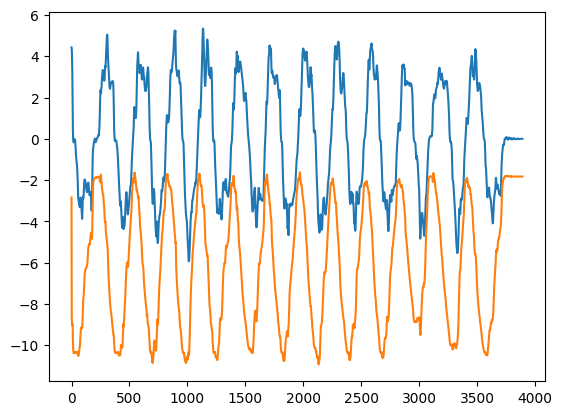

In [86]:
import matplotlib.pyplot as plt
Data = np.load('/home/hcr-sim-pc/Exo/Deploy/data-250123-0111-100hz.npy')


Torque= []
for val in Data[200:]:
    feature = np.delete(feature, (0), axis=0)
    feature = np.vstack([feature, [val[2], val[3], T.cpu().numpy()]])
    feature_tensor = torch.tensor(feature.reshape([1, 12]), dtype=torch.float32)#.to(device)
    with torch.no_grad(): T = model(feature_tensor)[0][0]

    Torque.append(T)

plt.plot(Data[200:].T[3]/10)
plt.plot(Torque)

## Online Deployment

In [7]:
## Temporary live data collection for testing
import socket
import threading

socket.gethostname()
srx = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
srx.bind(("0.0.0.0", 2025))
srx.listen(5)

stx = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
stx.bind(("0.0.0.0", 2027))
stx.listen(5)

In [32]:
client_rx, address = srx.accept()
client_tx, address = stx.accept()
client_tx.send(bytes("connected", "utf-8"))

print(address)

('172.16.0.1', 37112)


In [ ]:
Data, buffer = [], ""
for i in range(100000):
    buffer += client_rx.recv(44).decode("utf-8")
    try:
        msg, buffer = buffer.split(';', 1)
        msg = msg.split(";")[0].split(',')

        j, q, w = float(msg[1]), float(msg[2]), float(msg[3])
        if j!=0: 
            feature = np.delete(feature, (0), axis=0)
            feature = np.vstack([feature, [q, w, T]])
            T = model(feature.reshape([1, 12]))

            Data.append([i, j, q, w, T])
            client_tx.send(bytes(f"  {int(j*1000)}, {int(T*100)}", "utf-8"))
            print(f"{T} :: {j}: {Data[-1]}", end='\r')
    except: pass

print(len(Data), Data[0], Data[-1])

15560 [1, 125.207, 1.183892, 0.692378, 0.2392873466014862] [18967, 436.387, 0.996747, -0.992541, -0.03125755488872528]


In [13]:
len(Data)/Data[-1][1], len(bytes(f"  {int(j*100)}, OK, {int(T*100)}, OK;", "utf-8"))

(50.0008718243797, 23)

In [14]:
srx.close()
stx.close()

In [15]:
from datetime import datetime as dt
import matplotlib.pyplot as plt

import numpy as np

FILE = dt.now().strftime(f'%y%m%d-%H%M')
np.save(f'data-{FILE}-100hz', Data)

len(Data), Data[-1]

(22445, [26473, 448.89, 1.2449106305240805, -0.3178226241924528, -35])

In [22]:
Info = np.load(f'data-{FILE}-100hz.npy')

(array([ 1.8300000e+03,  3.0010000e+01,  1.8692408e+00, -3.5665894e-01,
        -4.2600000e+02]),
 array([ 3.00200000e+03,  4.99900000e+01,  1.90605634e+00, -2.39258722e-01,
        -5.14000000e+02]))

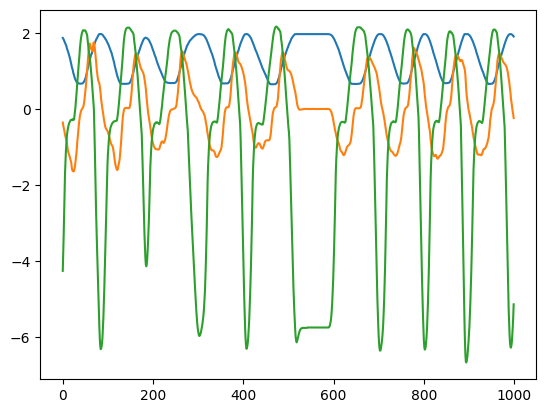

In [28]:
Data = Info[1500:2500]
plt.plot(np.array(Data).T[2])
plt.plot(np.array(Data).T[3])
plt.plot(np.array(Data).T[4]/100)

Data[0], Data[-1]

# Forecasting models
# 